# Text Clustering

In [1]:
import pandas as pd

df = pd.read_csv('./text_to_cluster.txt', sep='::', header=None)
df

/home/sourish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,0
0,Ransomware attack at Mexico's Pemex halts work...
1,#city | #ransomware | Ransomware Attack At Mex...
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ..."
3,A Mexican oil company was hit by ransomware at...
4,Pemex Struck by Ransomware Attack
...,...
679,Detecting and Responding to Ransomware
680,"Emotet malware is back, more dangerous than ever"
681,Hosting provider SmarterASP.NET hit by ransomw...
682,Ransomware as a Service (RaaS) – A Contemporar...


In [2]:
document = list(df[0].values)
document

["Ransomware attack at Mexico's Pemex halts work, threatens to cripple computers",
 '#city | #ransomware | Ransomware Attack At Mexico’s Pemex Halts Work, Threatens To Cripple Computers',
 "Mexico's Pemex Oil Suffers Ransomware Attack, $4.9 Million Demanded",
 'A Mexican oil company was hit by ransomware attack',
 'Pemex Struck by Ransomware Attack',
 'Mexico’s Pemex Said It Quickly Neutralized Digital Attack',
 'Ransomware attack hits Mexican state oil firm Pemex',
 'Ransomware Attack at Mexican State Oil Firm Halts Work, Threatens to Cripple Computers – GetAps.site',
 'Mexican state oil firm Pemex hit by ransomware attack',
 'Ransomware attack on the Mexican oil giant Pemex',
 "Ransomware attack at Mexico's Pemex halts work, threatens to cripple computers By Reuters",
 "Ransomware Attack Hits Mexico's State Oil Firm Pemex",
 'Spain’s Largest Radio Station Under Siege By Bitcoin Ransomware Attack',
 'Ransomware Attack Hits Web Hosting Provider SmarterASP',
 'ASP.NET hosting provider r

In [3]:
len(document)

684

In [4]:
from nltk import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re

def cleanText(data):
    """
    Clean Text
    - Keep only letters
    - Remove stopwords
    - Stem words
    """
    stemmer = PorterStemmer()
    text = re.sub('[^a-zA-Z]', ' ', data)
    words = nltk.word_tokenize(text.lower())
    stops = set(stopwords.words('english'))
    lem_words = [stemmer.stem(w) for w in words if w not in stops]
    return ' '.join(lem_words)

In [5]:
X_clean = []
for i in range(len(document)):
    X_clean.append(cleanText(document[i]))
X_clean

['ransomwar attack mexico pemex halt work threaten crippl comput',
 'citi ransomwar ransomwar attack mexico pemex halt work threaten crippl comput',
 'mexico pemex oil suffer ransomwar attack million demand',
 'mexican oil compani hit ransomwar attack',
 'pemex struck ransomwar attack',
 'mexico pemex said quickli neutral digit attack',
 'ransomwar attack hit mexican state oil firm pemex',
 'ransomwar attack mexican state oil firm halt work threaten crippl comput getap site',
 'mexican state oil firm pemex hit ransomwar attack',
 'ransomwar attack mexican oil giant pemex',
 'ransomwar attack mexico pemex halt work threaten crippl comput reuter',
 'ransomwar attack hit mexico state oil firm pemex',
 'spain largest radio station sieg bitcoin ransomwar attack',
 'ransomwar attack hit web host provid smarterasp',
 'asp net host provid recov ransomwar attack',
 'host provid smarterasp net recov ransomwar attack',
 'smarterasp net host network crippl ransomwar attack',
 'ransomwar attack dow

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X_clean)

In [7]:
terms = vectorizer.get_feature_names()
len(terms)

831

In [8]:
terms

['abil',
 'abort',
 'abus',
 'academ',
 'access',
 'acsc',
 'activ',
 'actor',
 'actual',
 'ad',
 'add',
 'adob',
 'advanc',
 'advic',
 'advis',
 'affair',
 'affect',
 'africa',
 'agenc',
 'ahead',
 'ai',
 'aim',
 'alert',
 'allow',
 'alter',
 'altern',
 'alyssa',
 'amandacerni',
 'amazon',
 'amd',
 'amid',
 'analysi',
 'android',
 'anoth',
 'anti',
 'antiviru',
 'aol',
 'api',
 'apolog',
 'app',
 'appl',
 'apt',
 'arbitrari',
 'arizona',
 'arriv',
 'asean',
 'asia',
 'ask',
 'asp',
 'assault',
 'asset',
 'asu',
 'asynchron',
 'atm',
 'attach',
 'attack',
 'attempt',
 'attract',
 'august',
 'aussi',
 'australian',
 'authent',
 'autumn',
 'av',
 'avast',
 'averag',
 'avoid',
 'axiom',
 'backdoor',
 'backslid',
 'backup',
 'bad',
 'bait',
 'bank',
 'beat',
 'becker',
 'begin',
 'believ',
 'belong',
 'berhad',
 'best',
 'beta',
 'bewar',
 'biggest',
 'billabong',
 'bitcoin',
 'bitdefend',
 'bite',
 'bitmex',
 'black',
 'blackberri',
 'blue',
 'bluekeep',
 'boardrid',
 'boost',
 'botch',
 

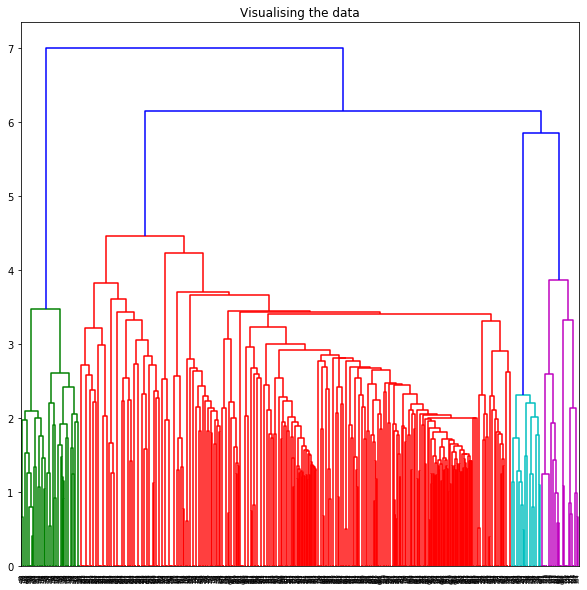

In [9]:
import scipy.cluster.hierarchy as shc 
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize =(10, 10)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(X.toarray(), method ='ward'))) 

In [10]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
from kneed import KneeLocator
import math

max_cluster = math.sqrt(len(df))

sse = {}
distortions = {}

for k in range(5, 20):
    kmeans = KMeans(n_clusters=k).fit(X)
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_
    distortions[k] = sum(np.min(cdist(X.toarray(), kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]

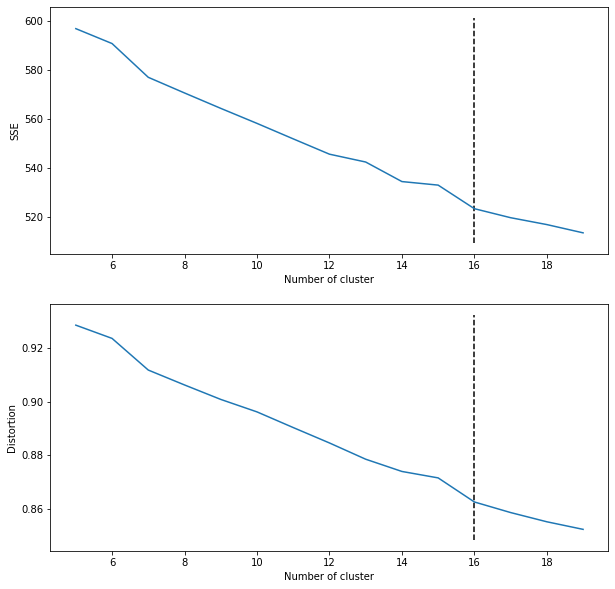

In [11]:
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
sse_kn = KneeLocator(list(sse.keys()), list(sse.values()), curve='convex', direction='decreasing')
plt.vlines(sse_kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.subplot(2, 1, 2)
plt.plot(list(distortions.keys()), list(distortions.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Distortion")
dis_kn = KneeLocator(list(distortions.keys()), list(distortions.values()), curve='convex', direction='decreasing')
plt.vlines(dis_kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.show()

In [12]:
from sklearn.metrics import silhouette_score

score = {}
for k in [sse_kn.knee, dis_kn.knee]:
    model = KMeans(n_clusters=k)
    clusters = model.fit_predict(X)
    score[k] = silhouette_score(X.toarray(), clusters, metric='euclidean')
    print(k, '-> ', score[k])

opt_score = max(score.values())
k = list(score.keys())[list(score.values()).index(opt_score)]
print('Optimal k is : ', k)

16 ->  0.1021008625879284
16 ->  0.10807192306520079
Optimal k is :  16


In [13]:
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X)
df['cluster'] = clusters
df = df.sort_values('cluster')
df

,0,cluster
552,TA505 Cybercrime targets system integrator com...,0
399,Telegram MTProxy Servers Used to DDoS Iranian ...,0
545,How To Remove Nonamebnm Scam Pop-ups From Mac,0
662,Tips for Staying Safe Online,0
493,"Cybersecurity Must Do More Than Prevention, Re...",0
...,...,...
328,5 Ways to Defend Your Business Against a Data ...,15
40,The Hidden Costs Your Business Incurs from a D...,15
104,The Hidden Costs Your Business Incurs from a D...,15
27,"33% of businesses hit by DDoS attack in 2017, ...",15


In [14]:
with open('output.txt', 'w+') as file:
    for i in range(max(clusters)+1):
        file.write(f'cluster_id:{i}\n')
        file.write('\n'.join(list(df[df['cluster']==i][0])))
        file.write('\n' + '*'*100 + '\n')